# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [57]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *
from modules.data_import import *

## Options

In [58]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [92]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam', 'l2':(1e-5)*(1e-5)}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [60]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [61]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

def reconvert_event(in_data):
    move_to_cartesian(in_data, 'PRI_tau', drop=False)
    move_to_cartesian(in_data, 'PRI_lep', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_leading', drop=False)
    move_to_cartesian(in_data, 'PRI_jet_subleading', drop=False)
    move_to_cartesian(in_data, 'PRI_met', z=False)

id = 19
nom = pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]

z_flip = nom.copy()
z_flip_event(z_flip)
reconvert_event(z_flip)

rot = nom.copy()
rotate_event(rot)
reconvert_event(rot)

rot_y = nom.copy()
rotate_event(rot_y)
y_flip_event(rot_y)
reconvert_event(rot_y)

rot_yz = nom.copy()
rotate_event(rot_yz)
y_flip_event(rot_yz)
z_flip_event(rot_yz)
reconvert_event(rot_yz)

comp_events([nom, rot, rot_y, rot_yz])

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


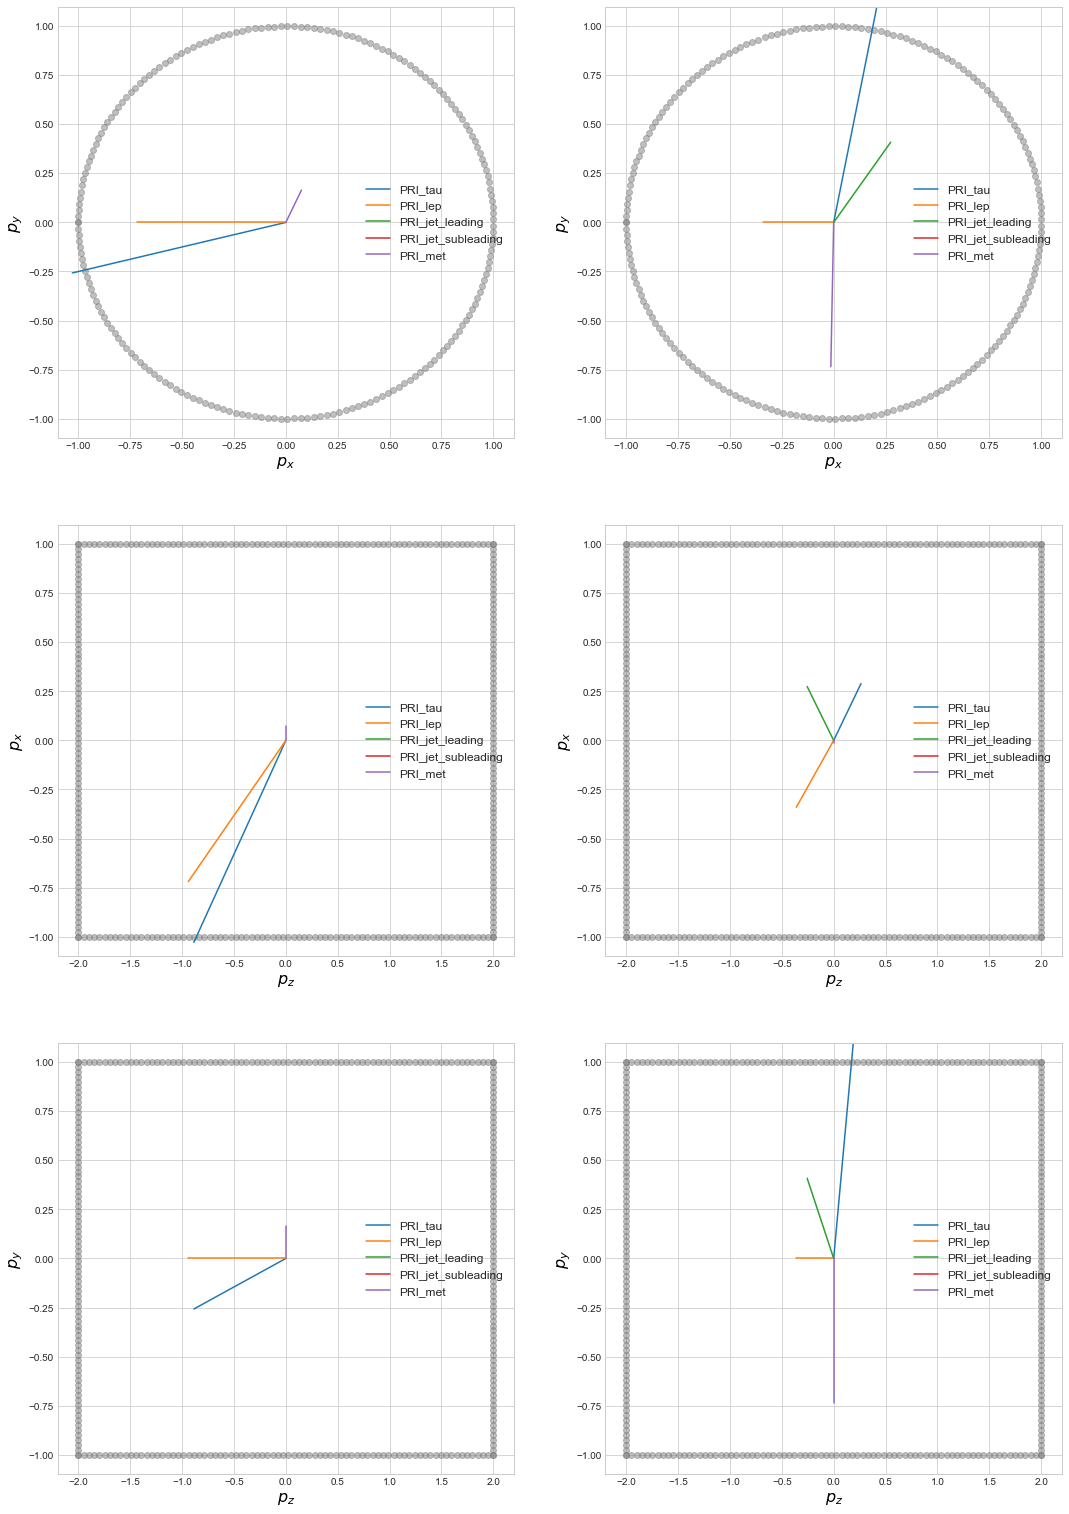

In [62]:
id = 0
pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1]
comp_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1],
             pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id+1:id+2]])

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.084s 


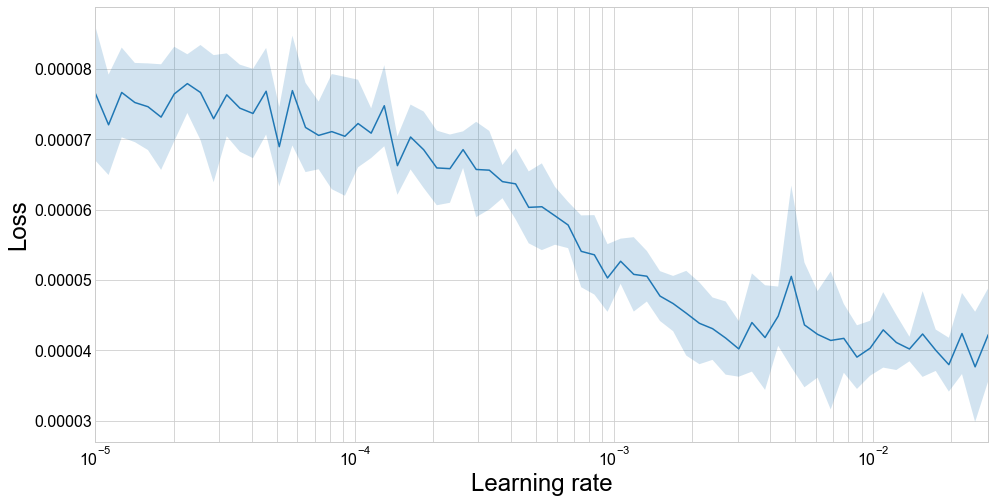

______________________________________



In [63]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300113). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299879). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303247). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.309491). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.304711). Check your callbacks.
  % delta_t_med


______________________________________
Training finished
Cross-validation took 72.349s 


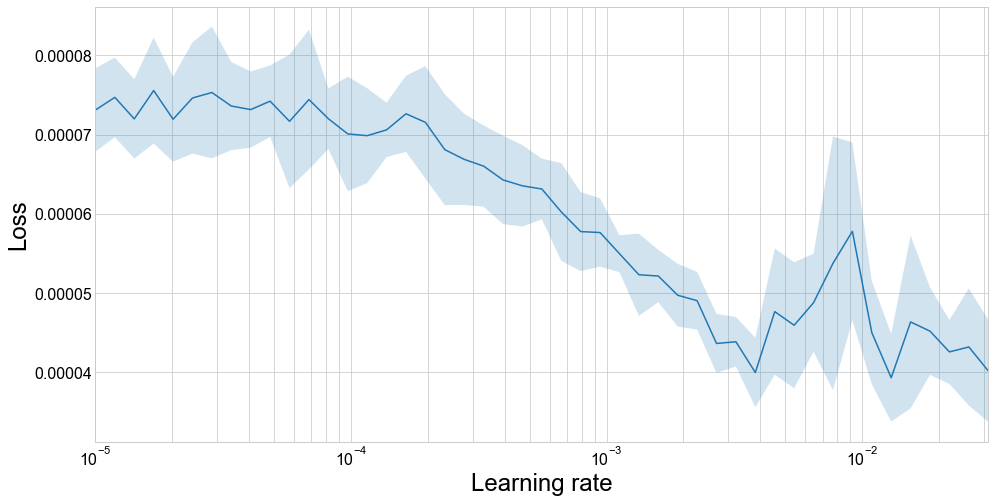

______________________________________



In [93]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e1], train_on_weights=True, verbose=0)

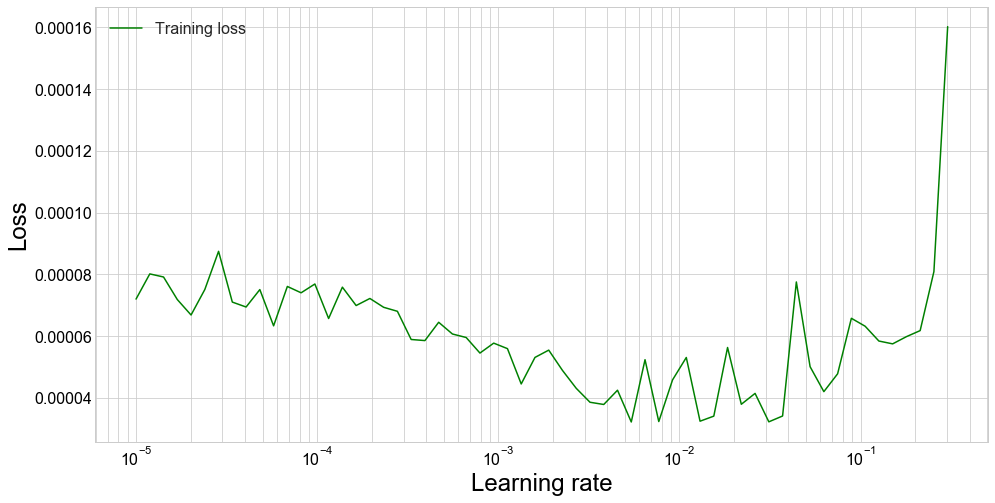

In [94]:
lr_finder[0].plot()

## Train classifier

In [95]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

In [96]:
model_gen_params

{'version': 'modelSwish',
 'n_in': 30,
 'compile_args': {'loss': 'binary_crossentropy',
  'optimizer': 'adam',
  'l2': 1.0000000000000002e-10,
  'lr': 0.002,
  'amsgrad': False,
  'beta_1': 0.9},
 'mode': 'classifier'}

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.275034). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.138621). Check your callbacks.
  % delta_t_median)


1 New best found: 3.843150036107181e-05
2 New best found: 3.540927758933506e-05
3 New best found: 3.486170645917882e-05
4 New best found: 3.464419667875897e-05
5 New best found: 3.40750972881181e-05
6 New best found: 3.3511535636493904e-05
7 New best found: 3.3193020523505156e-05
12 New best found: 3.2839677306722076e-05
13 New best found: 3.266264966000995e-05
15 New best found: 3.2581075066031216e-05
22 New best found: 3.257736483389805e-05
25 New best found: 3.2495443016589274e-05
26 New best found: 3.238903066320866e-05
28 New best found: 3.2332397284825156e-05
29 New best found: 3.2320333625040546e-05
30 New best found: 3.224375065959854e-05
31 New best found: 3.223952615889565e-05
50 New best found: 3.2144553830708287e-05
55 New best found: 3.2103428280092225e-05
57 New best found: 3.207362361745765e-05
58 New best found: 3.204160431435031e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00011866523563337161
Early stopping after 137 epochs
Score is: {'loss

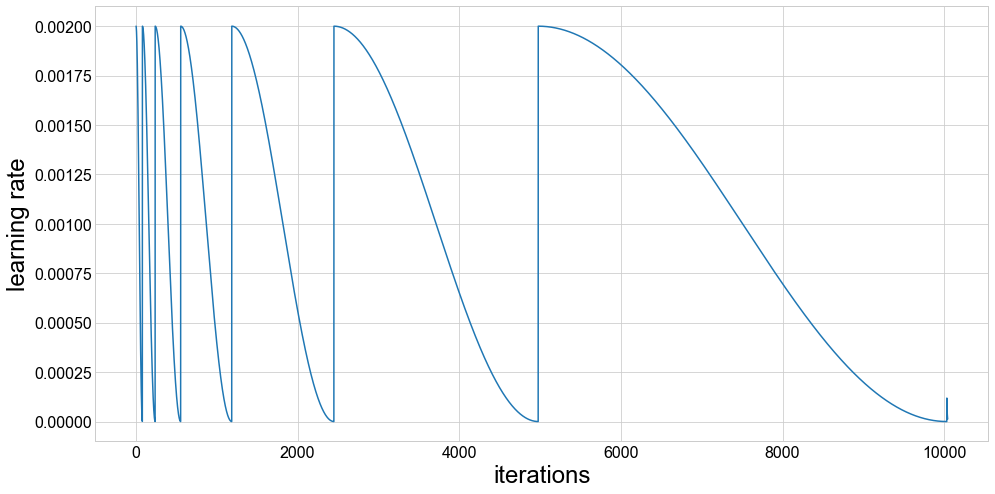

Fold took 326.295s

Training model 2 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.237084). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.119510). Check your callbacks.
  % delta_t_median)


1 New best found: 3.691025886218995e-05
2 New best found: 3.6281154026073634e-05
3 New best found: 3.4265076075098476e-05
4 New best found: 3.40054796775803e-05
5 New best found: 3.352887656074017e-05
6 New best found: 3.275486135971732e-05
7 New best found: 3.270889879495371e-05
11 New best found: 3.255447817791719e-05
13 New best found: 3.228592822415521e-05
14 New best found: 3.223382942960598e-05
15 New best found: 3.219708043470746e-05
18 New best found: 3.2167619958636354e-05
24 New best found: 3.215598456881707e-05
25 New best found: 3.193446512523224e-05
27 New best found: 3.1882188205781855e-05
28 New best found: 3.18326088032336e-05
30 New best found: 3.179659249726683e-05
31 New best found: 3.1794886774878254e-05
47 New best found: 3.177557037342922e-05
51 New best found: 3.1704230339528294e-05
54 New best found: 3.166611198612372e-05
58 New best found: 3.16264996487007e-05
59 New best found: 3.161309232818894e-05
60 New best found: 3.158229512409889e-05
61 New best found: 3

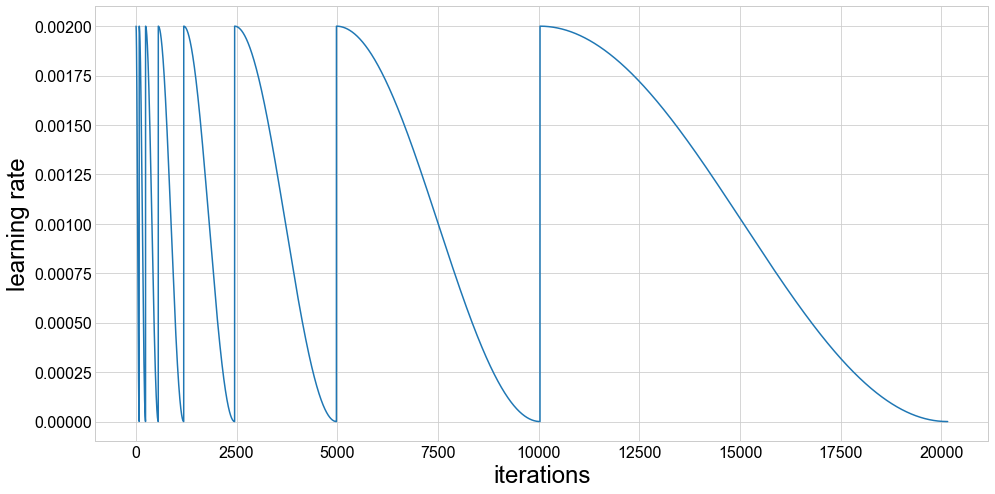

Fold took 611.303s

Training model 3 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.237268). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.119589). Check your callbacks.
  % delta_t_median)


1 New best found: 3.626514354530975e-05
2 New best found: 3.382113943247907e-05
3 New best found: 3.324397671845379e-05
4 New best found: 3.316778628460213e-05
5 New best found: 3.275296158345872e-05
6 New best found: 3.235493924675926e-05
7 New best found: 3.2305284141879035e-05
11 New best found: 3.225261899442339e-05
12 New best found: 3.2038449195369425e-05
13 New best found: 3.1880264576993275e-05
14 New best found: 3.181164809170807e-05
15 New best found: 3.179638936673461e-05
24 New best found: 3.174057124051211e-05
25 New best found: 3.169910453312244e-05
27 New best found: 3.1643856266857686e-05
28 New best found: 3.157056655170634e-05
29 New best found: 3.154808214839165e-05
30 New best found: 3.1520262009321875e-05
55 New best found: 3.151460860056369e-05
56 New best found: 3.143850714665836e-05
57 New best found: 3.1402669939251774e-05
58 New best found: 3.1400532131874125e-05
59 New best found: 3.139176220050247e-05
60 New best found: 3.1386612357264045e-05
CosineAnneal st

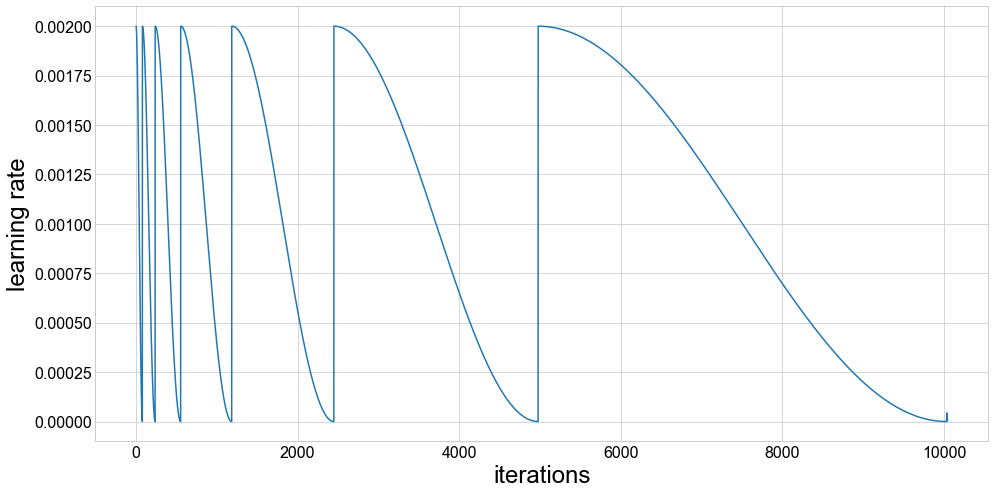

Fold took 291.207s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.209907). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.105950). Check your callbacks.
  % delta_t_median)


1 New best found: 3.950079040805576e-05
2 New best found: 3.6527392225980296e-05
3 New best found: 3.5815767699386926e-05
5 New best found: 3.5017441368836445e-05
6 New best found: 3.4734343767922836e-05
7 New best found: 3.4616864810232075e-05
10 New best found: 3.444341286522104e-05
12 New best found: 3.423075451573823e-05
13 New best found: 3.394272862933576e-05
14 New best found: 3.388581114704721e-05
15 New best found: 3.3818078867625444e-05
23 New best found: 3.353003493102733e-05
28 New best found: 3.349653531913646e-05
29 New best found: 3.34336766602064e-05
30 New best found: 3.340071300335694e-05
48 New best found: 3.339652251524967e-05
50 New best found: 3.338026051133056e-05
51 New best found: 3.3378853540489214e-05
53 New best found: 3.3354805803537604e-05
54 New best found: 3.334659817483043e-05
56 New best found: 3.3318528906238497e-05
57 New best found: 3.318356413510628e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00016922145506649905
Early 

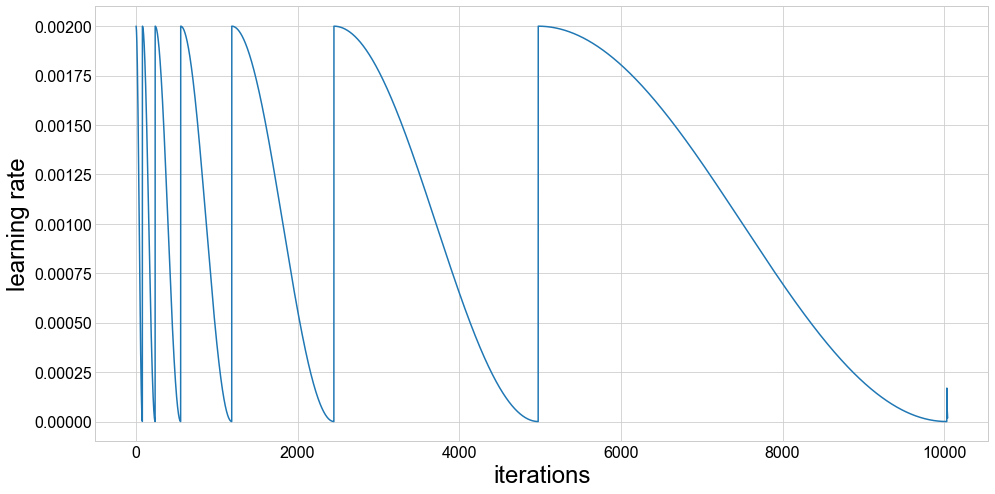

Fold took 276.871s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.219259). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.110563). Check your callbacks.
  % delta_t_median)


1 New best found: 3.728022080514444e-05
2 New best found: 3.470737040703771e-05
3 New best found: 3.4166995247622296e-05
4 New best found: 3.374997765908453e-05
6 New best found: 3.321873709781808e-05
7 New best found: 3.308146917106649e-05
10 New best found: 3.307786273474898e-05
11 New best found: 3.292770778578353e-05
12 New best found: 3.2771605789349736e-05
13 New best found: 3.262064053549576e-05
14 New best found: 3.249939603237332e-05
20 New best found: 3.239158251733988e-05
24 New best found: 3.233057111596621e-05
25 New best found: 3.227480559853756e-05
28 New best found: 3.221881091472978e-05
29 New best found: 3.2133908480501316e-05
31 New best found: 3.211116402054459e-05
46 New best found: 3.206603306626735e-05
52 New best found: 3.2021035513247634e-05
56 New best found: 3.2008867386315756e-05
57 New best found: 3.197581968550148e-05
58 New best found: 3.1942031171578854e-05
CosineAnneal stalling after 127 epochs, entering redux decay at LR=0.00011866523563337161
130 New 

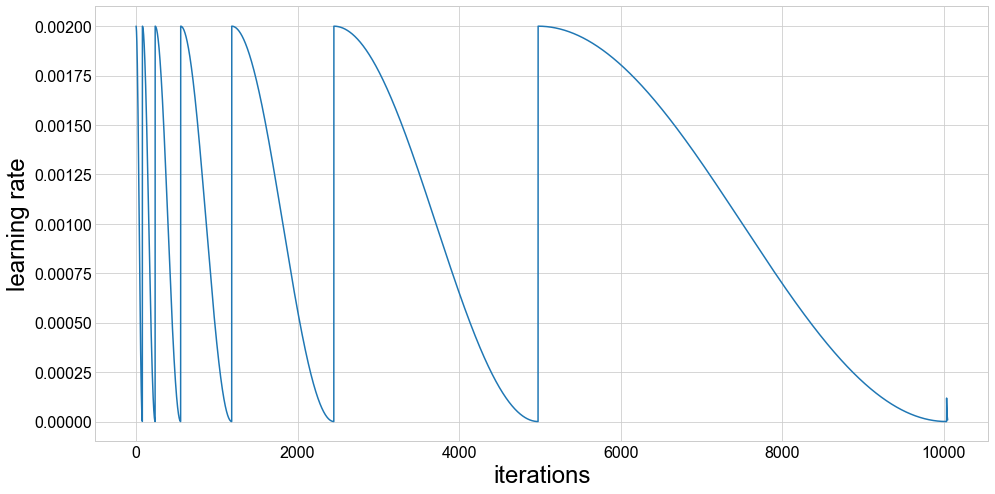

Fold took 291.069s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.241988). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.121930). Check your callbacks.
  % delta_t_median)


1 New best found: 3.653878699091541e-05
2 New best found: 3.371708963679292e-05
3 New best found: 3.3283554579508116e-05
5 New best found: 3.228890180635134e-05
6 New best found: 3.202438390242273e-05
7 New best found: 3.1993746751296876e-05
11 New best found: 3.178027354846106e-05
12 New best found: 3.1503265416829946e-05
14 New best found: 3.139665589736831e-05
15 New best found: 3.1348883755130985e-05
23 New best found: 3.1317181436309585e-05
26 New best found: 3.131696718687323e-05
27 New best found: 3.1151507272899413e-05
28 New best found: 3.110415943297227e-05
29 New best found: 3.100923593949647e-05
30 New best found: 3.099435225452911e-05
51 New best found: 3.093030012529933e-05
55 New best found: 3.091456561240382e-05
56 New best found: 3.082787692651935e-05
58 New best found: 3.081575979546351e-05
59 New best found: 3.081541963398639e-05
60 New best found: 3.079368294545654e-05
61 New best found: 3.079353314770941e-05
CosineAnneal stalling after 127 epochs, entering redux de

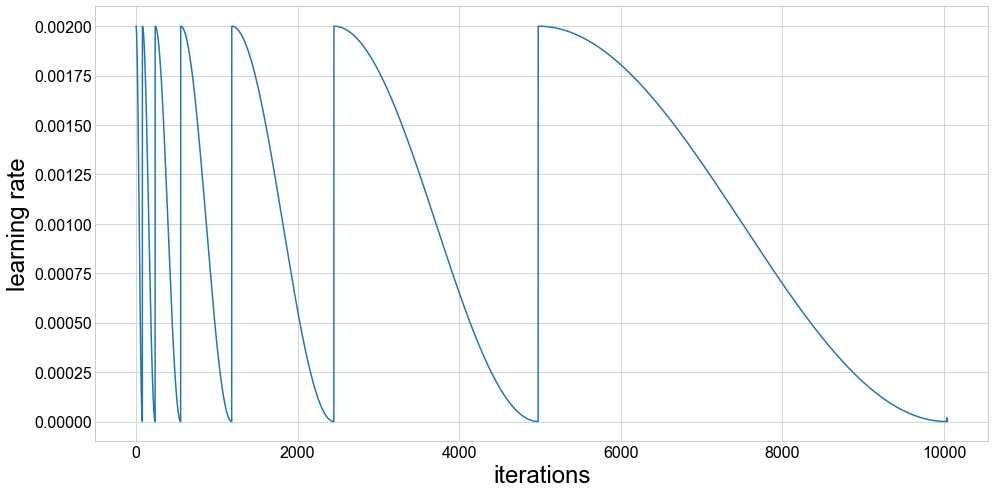

Fold took 286.269s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.346807). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.174654). Check your callbacks.
  % delta_t_median)


1 New best found: 3.745130324011315e-05
2 New best found: 3.544062700491338e-05
3 New best found: 3.4614453587264887e-05
5 New best found: 3.386879373395137e-05
6 New best found: 3.372684842479481e-05
7 New best found: 3.3272791361059266e-05
11 New best found: 3.323281612382525e-05
12 New best found: 3.305645328549692e-05
13 New best found: 3.2635904745927796e-05
14 New best found: 3.263047844832153e-05
22 New best found: 3.256301851904469e-05
24 New best found: 3.248382768853199e-05
26 New best found: 3.2371025862509615e-05
27 New best found: 3.2261230056500314e-05
28 New best found: 3.21650618820762e-05
29 New best found: 3.2149421707390206e-05
51 New best found: 3.214047059605685e-05
52 New best found: 3.209134916612853e-05
53 New best found: 3.2056396811869455e-05
55 New best found: 3.202021706006151e-05
58 New best found: 3.199019731609605e-05
60 New best found: 3.1983877437466796e-05
61 New best found: 3.196467161079064e-05
62 New best found: 3.1962724816621236e-05
63 New best fo

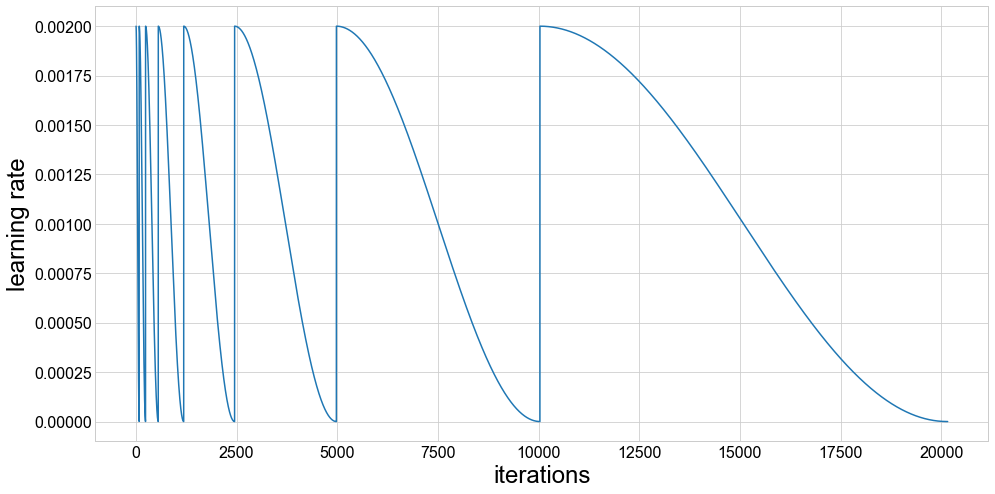

Fold took 532.198s

Training model 8 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.331751). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.166835). Check your callbacks.
  % delta_t_median)


1 New best found: 3.701778271642979e-05
2 New best found: 3.5277250011858995e-05
3 New best found: 3.487588789575966e-05
5 New best found: 3.43780936251278e-05
6 New best found: 3.3590357092907654e-05
7 New best found: 3.3502101004705764e-05
12 New best found: 3.313048587006051e-05
13 New best found: 3.289606031612493e-05
14 New best found: 3.2848076130903795e-05
15 New best found: 3.279832033731509e-05
20 New best found: 3.2789502634841484e-05
24 New best found: 3.2555237400811163e-05
25 New best found: 3.25526779066422e-05
26 New best found: 3.253113906393992e-05
27 New best found: 3.233774062100565e-05
28 New best found: 3.229942685429705e-05
29 New best found: 3.2273186037491545e-05
30 New best found: 3.2271202323317994e-05
31 New best found: 3.226871934457449e-05
46 New best found: 3.219330782303587e-05
51 New best found: 3.217401737783803e-05
52 New best found: 3.2097183207224586e-05
55 New best found: 3.201714339811588e-05
56 New best found: 3.2008259725989775e-05
57 New best fo

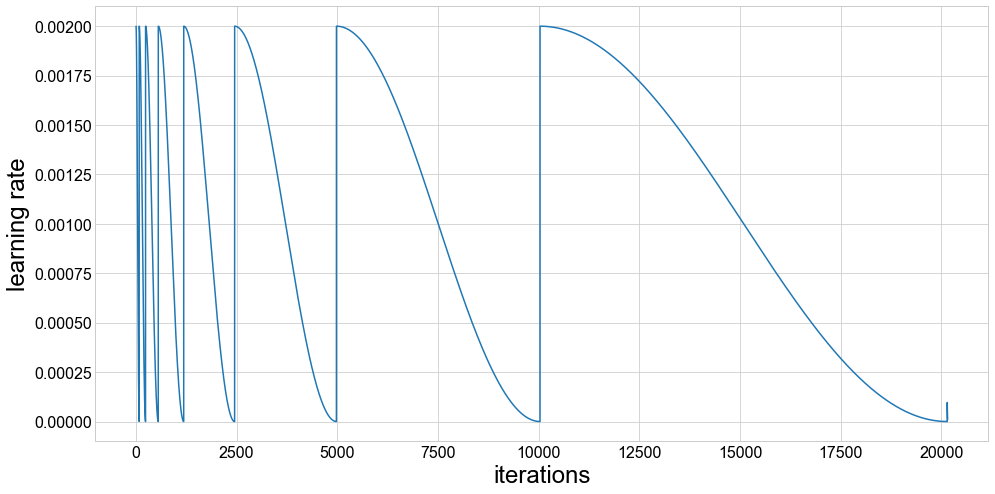

Fold took 556.444s

Training model 9 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.459967). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.231047). Check your callbacks.
  % delta_t_median)


1 New best found: 3.696325122020803e-05
2 New best found: 3.480915760846785e-05
3 New best found: 3.423283244452139e-05
4 New best found: 3.38914687404457e-05
5 New best found: 3.3132150373917766e-05
6 New best found: 3.278675835146967e-05
12 New best found: 3.2357972569816785e-05
13 New best found: 3.215175001320209e-05
14 New best found: 3.212986627637202e-05
15 New best found: 3.2102235028722055e-05
22 New best found: 3.205579720747586e-05
25 New best found: 3.197277142304179e-05
26 New best found: 3.191182974159167e-05
27 New best found: 3.175787919780298e-05
29 New best found: 3.173945963825729e-05
30 New best found: 3.1730944945369276e-05
31 New best found: 3.1725352994635026e-05
48 New best found: 3.168814551887814e-05
52 New best found: 3.161029413916647e-05
53 New best found: 3.157967415988582e-05
57 New best found: 3.1573882235822914e-05
58 New best found: 3.148412513236629e-05
59 New best found: 3.1477998471617015e-05
60 New best found: 3.145315448560554e-05
CosineAnneal sta

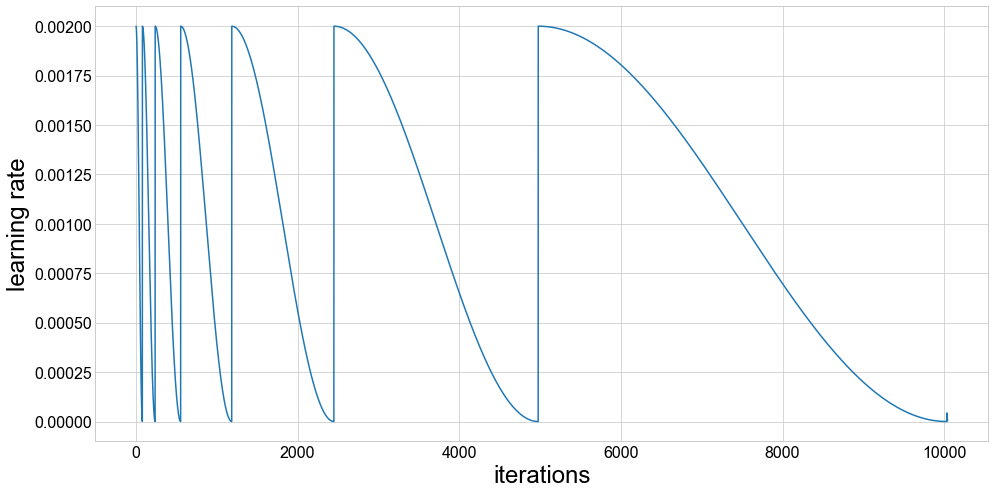

Fold took 413.611s

Training model 10 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.335814). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.168913). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7285896539106036e-05
2 New best found: 3.5077053704299034e-05
3 New best found: 3.459348073083674e-05
5 New best found: 3.374363376933616e-05
6 New best found: 3.346027692459757e-05
7 New best found: 3.342992453544866e-05
9 New best found: 3.3415385836269704e-05
10 New best found: 3.329246349894674e-05
11 New best found: 3.302045553282369e-05
12 New best found: 3.285321707953699e-05
13 New best found: 3.2850193946796935e-05
14 New best found: 3.265910959307803e-05
24 New best found: 3.251015966234263e-05
26 New best found: 3.2503050565719604e-05
27 New best found: 3.248074599832762e-05
28 New best found: 3.2397551235044374e-05
29 New best found: 3.2384943813667635e-05
30 New best found: 3.235395007068291e-05
50 New best found: 3.215321507159388e-05
51 New best found: 3.2148136367322875e-05
57 New best found: 3.212739507580409e-05
59 New best found: 3.209916381892981e-05
60 New best found: 3.2068629597779366e-05
114 New best found: 3.206096486828756e-05
CosineAnneal 

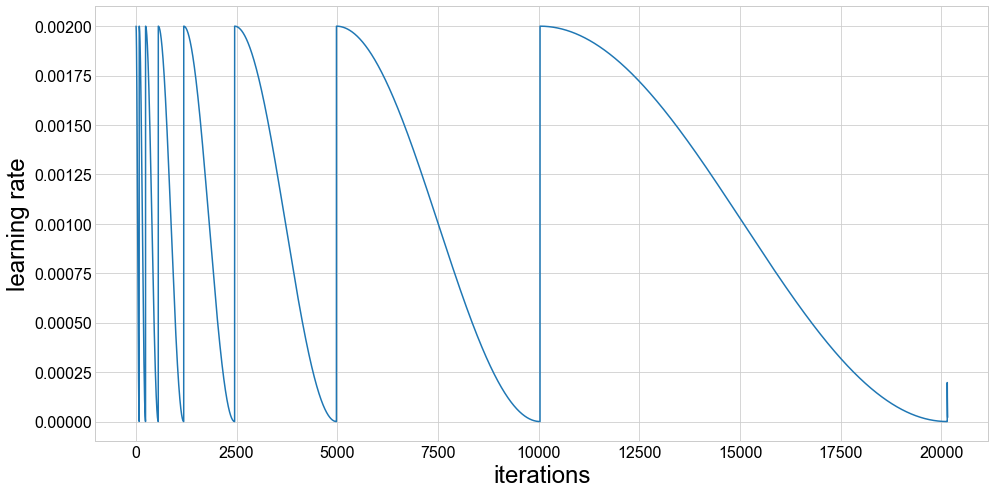

Fold took 577.792s


______________________________________
Training finished
Cross-validation took 4191.014s 


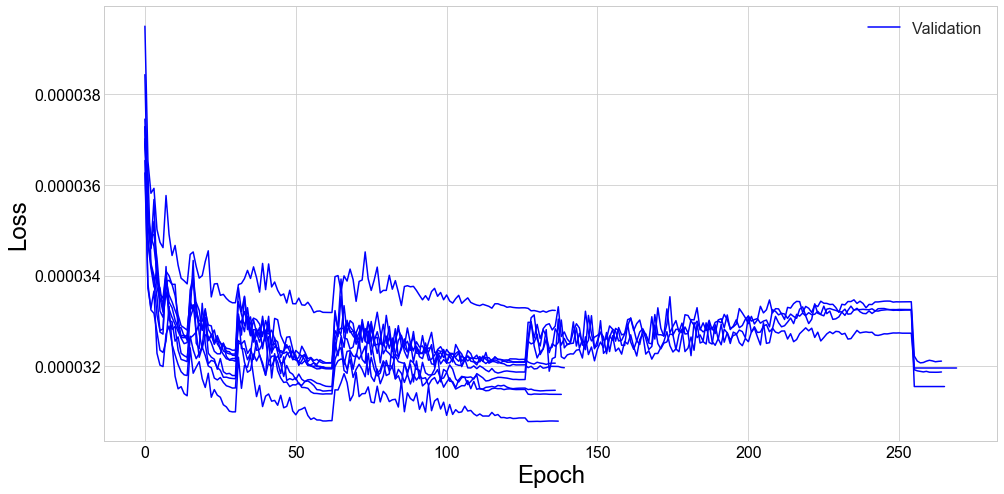

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0631 +- 0.0007
Mean AUC = 0.0983 +- 0.0008
Mean AMS = 3.94 +- 0.09
Mean cut = 0.963 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [97]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [98]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [99]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 5 with loss = 3.078152307002546e-05
Model 1 is 2 with loss = 3.1376890275256475e-05
Model 2 is 8 with loss = 3.145315448560554e-05
Model 3 is 1 with loss = 3.155328709981404e-05
Model 4 is 7 with loss = 3.185071890911786e-05
Model 5 is 4 with loss = 3.194105202192539e-05
Model 6 is 6 with loss = 3.1962126586123755e-05
Model 7 is 0 with loss = 3.204160431435031e-05
Model 8 is 9 with loss = 3.206096486828756e-05
Model 9 is 3 with loss = 3.318356413510628e-05


## Response on validation data without TTA

In [100]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [101]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.006183043973399981s per sample

Predicting fold 2 out of 10
Prediction took 0.0006811034627997287s per sample

Predicting fold 3 out of 10
Prediction took 0.0007851351490000525s per sample

Predicting fold 4 out of 10
Prediction took 0.0006844306073999178s per sample

Predicting fold 5 out of 10
Prediction took 0.0008074020067997481s per sample

Predicting fold 6 out of 10
Prediction took 0.0009672393811997608s per sample

Predicting fold 7 out of 10
Prediction took 0.000822330718000012s per sample

Predicting fold 8 out of 10
Prediction took 0.0007943347693999386s per sample

Predicting fold 9 out of 10
Prediction took 0.0008182738486000744s per sample

Predicting fold 10 out of 10
Prediction took 0.0007538045535999117s per sample



In [102]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [103]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9038713630642242, weighted 0.9360698562762075


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Best cut at 0.9639268870706912 corresponds to AMS of 3.858331438395997
Maximum AMS for data is 3.9164270452562584 at cut of 0.9658254384994507
CPU times: user 13.9 s, sys: 39.4 ms, total: 13.9 s
Wall time: 14 s


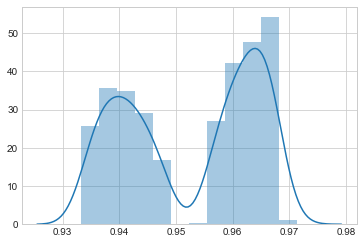

In [104]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9527781 corresponds to AMS of 3.7393067695167805
Maximum AMS for data is 3.9164270452562584 at cut of 0.9658254384994507
CPU times: user 52.2 ms, sys: 4.6 ms, total: 56.8 ms
Wall time: 53.5 ms


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


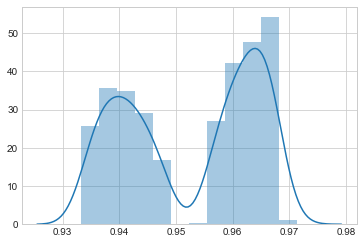

In [105]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [106]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [107]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0007851120181454462s per sample

Predicting fold 2 out of 10
Prediction took 0.0007501830584909013s per sample

Predicting fold 3 out of 10
Prediction took 0.0007912039662727197s per sample

Predicting fold 4 out of 10
Prediction took 0.0007659830278909132s per sample

Predicting fold 5 out of 10
Prediction took 0.0007048516090909041s per sample

Predicting fold 6 out of 10
Prediction took 0.0007099419349091146s per sample

Predicting fold 7 out of 10
Prediction took 0.0007376015628181697s per sample

Predicting fold 8 out of 10
Prediction took 0.0007746570209272746s per sample

Predicting fold 9 out of 10
Prediction took 0.0007535338675090977s per sample

Predicting fold 10 out of 10
Prediction took 0.0007203211746363774s per sample

CPU times: user 7min 10s, sys: 14.2 s, total: 7min 24s
Wall time: 6min 52s


In [108]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.573776910382205 : 3.698248466468194


(3.573776910382205, 3.698248466468194)

In [109]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.7260100937926928 : 3.7552019949627304


(3.7260100937926928, 3.7552019949627304)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)